# ECON 696F Assignment 2

*Zejin Shi （shizejin94@gmail.com）*

In [1]:
import numpy as np
import pandas as pd
from numba import njit, prange
from interpolation import interp
from scipy.optimize import minimize

# set the precision for printing ndarray
np.set_printoptions(precision=3)

In [2]:
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
γ = 0.5772156649 # not used

In [4]:
# region (10) * lag_investment (2) * lag2_investent(2) * ordered_violator (3) * disc_violations (20)
n_naics_recode = 7
n_region = 10
n_Linv = 2
n_L2inv = 2
n_ordered_violator = 3
n_DAV = 20
n_vio = 2

# focus on the fist sector
sector = 0

In [5]:
# import the simulated data for bellman computation
f = open("/Users/hyde/Dropbox/UArizona/ECON 696/data_for_bellman_computations.csv")
lines = f.readlines()

simulated_dist = np.empty((n_naics_recode, n_region, n_Linv, n_L2inv, n_ordered_violator, n_DAV, 80, 7))

for line in lines[1:]:
    line = line.split(',')
    for i in range(80):
        simulated_dist[int(line[0])-1, int(line[1])-1, int(line[2]), int(line[3]), int(line[4]), int(line[5])-1][i] = [float(e) for e in line[7+7*i:14+7*i]]

In [6]:
# import observed data for quasilikelihood calculation
f = open("/Users/hyde/Dropbox/UArizona/ECON 696/analysis_data.csv")
lines = f.readlines()

# for i, col in enumerate(lines[0].split(',')):
#     print(col, i, i-2)

lines[0]
data = []
for line in lines[1:]:
    line = [e for e in line.strip().split(',')[2:18]]
    vio = int(line[2])
    Linv = int(line[4])
    inv = int(line[6])
    naics_recode = int(line[7])
    region = int(line[9])
    ordered_violator = int(line[13])
    DAV = float(line[15])
    
    if (naics_recode - 1) == sector:
        data.append([region-1, Linv, ordered_violator, DAV, vio, inv])
        
data = np.array(data)

In [7]:
def BGL(euler=0):
    """
    Factory functions for generating functions of Bellman operators 
    and quasilikelihood estimation of “Escalation of Scrutiny: 
    The Gains from Dynamic Enforcement of Environmental Regulations.” 
    NBER Working Paper 24810 [BGL]
    """
    
    # depreciation rate
    δ = 0.1
    
    # discount factor
    β = 0.95 ** (1/4.)
    
    # initialize V(Ω') and V(Ω)
    # set the initial values to be 0
    
    # the range of DAV for interpolation
    DAV_range = np.arange(0., 10.0, 0.5)
    
    @njit
    def initialize():
        """
        Initialize V(Ω') and V(Ω) matrices for value functions. 
        """
        # V(Ω')
        # Notice that L2inv is a useless state for Ω'
        VΩ_prime = np.zeros((n_region, n_Linv, n_ordered_violator, n_DAV, n_vio))
        # V(Ω) 
        VΩ = np.zeros((n_region, n_Linv, n_L2inv, n_ordered_violator, n_DAV))
        
        return VΩ_prime, VΩ
    
    @njit(parallel=True)
    def VΩ_prime_operator(VΩ_prime, VΩ, θ):
        """
        Bellman operator for updating VΩ using VΩ_prime values. (Eq. (2) in BGL)
        """
        θ_I, θ_F, θ_V, θ_H, θ_X = θ
        
        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for ordered_violator in prange(n_ordered_violator):
                    for i_DAV in prange(n_DAV):
                        for vio in prange(n_vio):
                            DAV = i_DAV * 0.5

                            # for compliance
                            if ordered_violator == 0:
                                if euler == 1:
                                    VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = β * VΩ[region, 0, Linv, ordered_violator, i_DAV] + γ
                                
                                elif euler == 0:
                                    # without Euler constant
                                    VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = β * VΩ[region, 0, Linv, ordered_violator, i_DAV]

                            else:

                                DAV_next = min((1 - δ) * DAV + vio, 9.5)
                                
                                if euler == 1:
                                    VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = \
                                        np.log(np.exp(β * interp(DAV_range, VΩ[region, 0, Linv, ordered_violator, :], DAV_next))
                                        + np.exp(θ_X + β * interp(DAV_range, VΩ[region, 1, Linv, ordered_violator, :], DAV_next))) + γ
                                elif euler == 0:
                                    # without Euler constant
                                    VΩ_prime[region, Linv, ordered_violator, i_DAV, vio] = \
                                        np.log(np.exp(β * interp(DAV_range, VΩ[region, 0, Linv, ordered_violator, :], DAV_next))
                                        + np.exp(θ_X + β * interp(DAV_range, VΩ[region, 1, Linv, ordered_violator, :], DAV_next)))



    @njit(parallel=True)
    def VΩ_operator(VΩ_prime, VΩ, θ):
        """
        Bellman operator for updating VΩ_prime using VΩ values. (Eq. (3) in BGL)
        """
        θ_I, θ_F, θ_V, θ_H, θ_X = θ
        
        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for L2inv in prange(n_L2inv):
                    for ordered_violator in prange(n_ordered_violator):
                        for i_DAV in prange(n_DAV):
                            
                            # find out the transitions
                            # for compliance
                            if (ordered_violator == 0):
                                transition = simulated_dist[sector, region, 0, 0, ordered_violator, 0]
                            # for regular violator and high priority violator
                            else:
                                transition = simulated_dist[sector, region, Linv, L2inv, ordered_violator, i_DAV]
                            
                            VΩ[region, Linv, L2inv, ordered_violator, i_DAV] = 0.
                            
                            for i in prange(80):
                                ins, vio, fine, prob, prob0, prob1, prob2 = transition[i]
                                util = θ_I * float(ins) + fine * θ_F + float(vio) * θ_V
                                
                                # if transit to compliance plant
                                util += prob0 * VΩ_prime[region, Linv, 0, 0, int(vio)]
                                
                                # if transit to regular violator or high priority violator
                                util += prob1 * VΩ_prime[region, Linv, 1, i_DAV, int(vio)]
                                util += prob2 * (VΩ_prime[region, Linv, 2, i_DAV, int(vio)] + θ_H)
                                
                                VΩ[region, Linv, L2inv, ordered_violator, i_DAV] += prob * util
    
    def solve_bellman(θ, tol=1e-7, verbose=True):
        """
        Wrap the procedure of initializing and iterating.
        """
        VΩ_prime, VΩ = initialize()

        dist = np.inf
        i = 0

        while dist > tol:

            VΩ_old = np.copy(VΩ)

            VΩ_operator(VΩ_prime, VΩ, θ)
            VΩ_prime_operator(VΩ_prime, VΩ, θ)

            dist = np.max(np.abs(VΩ_old - VΩ))
            i += 1

            if (i % 100 == 0) & (verbose):
                print(f'{i} times of iteration: error = {dist}')

        return VΩ_prime, VΩ
    
    @njit
    def solve_bellman_jitted(θ, tol=1e-7):
        """
        The jitted version of solve_bellman without printing.
        """
        VΩ_prime, VΩ = initialize()

        dist = np.inf

        while dist > tol:

            VΩ_old = np.copy(VΩ)

            VΩ_operator(VΩ_prime, VΩ, θ)
            VΩ_prime_operator(VΩ_prime, VΩ, θ)

            dist = np.max(np.abs(VΩ_old - VΩ))

        return VΩ_prime, VΩ

    @njit(parallel=True)
    def comute_CCP_inv(VΩ_prime, VΩ, θ):
        """
        Use value function to calculate CCP for investing.
        """
        CCP_inv = np.zeros_like(VΩ_prime)

        θ_I, θ_F, θ_V, θ_H, θ_X = θ

        for region in prange(n_region):
            for Linv in prange(n_Linv):
                for ordered_violator in prange(n_ordered_violator):
                    for i_DAV in prange(n_DAV):
                        for vio in prange(n_vio):
                            DAV = i_DAV * 0.5

                            # for compliance
                            # no investment
                            if ordered_violator == 0:
                                continue

                            else:

                                DAV_next = min((1 - δ) * DAV + vio, 9.5)
                                
                                # exponential value of no investment
                                exp_value_noinv = np.exp(β * interp(DAV_range, VΩ[region, 0, Linv, ordered_violator, :], DAV_next))
                                # exponential value of investment
                                exp_value_inv = np.exp(θ_X + β * interp(DAV_range, VΩ[region, 1, Linv, ordered_violator, :], DAV_next))
                                CCP_inv[region, Linv, ordered_violator, i_DAV, vio] = exp_value_inv / (exp_value_inv + exp_value_noinv)

        return CCP_inv
    
    @njit
    def quasilikelihood(CCP_inv, data):
        """
        Use CCP and observed data to calculate quasi-likelihood.
        """
        L = 0.
        for i in range(data.shape[0]):
            region, Linv, ordered_violator, DAV, vio, inv = data[i]
            CCP = interp(DAV_range, CCP_inv[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
            
            if inv == 1:
                L += np.log(CCP)
            else:
                L += np.log(1 - CCP)
                
        return L
    
    @njit
    def quasilikelihood_wrapped(θ, data):
        """
        Wrap the procedure of calculating value function, CCP, and quasilikelihood.
        Only takes parameter θ and data as inputs.
        """
        VΩ_prime, VΩ = solve_bellman_jitted(θ)
        CCP_inv = comute_CCP_inv(VΩ_prime, VΩ, θ)
        L = quasilikelihood(CCP_inv, data)
        
        # return -L because we want to use sp.optimize.minimize to do optimization
        return - L
    
    return initialize, VΩ_prime_operator, VΩ_operator, solve_bellman, solve_bellman_jitted, \
                comute_CCP_inv, quasilikelihood, quasilikelihood_wrapped

# 1)Compute the plant's dynamic optimization decision for the parameters 

## c. $\widehat{\theta} \equiv ( \theta^X = -2, \theta^I = -0.5, \theta^V = -0.5, \theta^F = -0.1, \theta^H = -0.1 )$. 

In [8]:
# ordered by θ_I, θ_F, θ_V, θ_H, θ_X
θ = (-0.5, -0.1, -0.5, -0.1, -2.)

In [9]:
# no euler constant
initialize, VΩ_prime_operator, VΩ_operator, solve_bellman, solve_bellman_jitted,\
comute_CCP_inv,quasilikelihood, quasilikelihood_wrapped = BGL(euler=0)

VΩ_prime_no_euler, VΩ_no_euler = solve_bellman(θ)

100 times of iteration: error = 0.22752409133430263
200 times of iteration: error = 0.020246156713767505
300 times of iteration: error = 0.0030130955647535984
400 times of iteration: error = 0.0006788794834307055
500 times of iteration: error = 0.00017885592946242923
600 times of iteration: error = 4.904215899159681e-05
700 times of iteration: error = 1.3569205364660775e-05
800 times of iteration: error = 3.7618193573507597e-06
900 times of iteration: error = 1.0433456623104576e-06
1000 times of iteration: error = 2.894003330311534e-07


In [10]:
# check the speed of each bellman value calculation
%timeit solve_bellman(θ, verbose=False)

1.02 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
CCP_inv_no_euler = comute_CCP_inv(VΩ_prime_no_euler, VΩ_no_euler, θ)

In [12]:
# # with euler constant
# initialize, VΩ_prime_operator, VΩ_operator, solve_bellman, comute_CCP_inv, quasilikelihood, quasilikelihood_wrapped, standard_error = BGL(euler=1)
# VΩ_prime_euler, VΩ_euler = solve_bellman(θ)

In [13]:
# CCP_inv_euler = comute_CCP_inv(VΩ_prime_euler, VΩ_euler, θ)

## Report the investment probability for all states with DAV = 2 (for which the integer grid takes on a value of 4).

In [14]:
i_DAV = 4 # DAV = 2

for region in range(n_region):
    for Linv in range(n_Linv):
        for ordered_violator in range(1, 3):
            for vio in range(2):
                print(f'region={region}, Linv={Linv}, ordered_violator={ordered_violator}, vio={vio}: \
                    Pr(inv=1) = {CCP_inv_no_euler[region, Linv, ordered_violator, i_DAV, vio]}')

region=0, Linv=0, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.10186601188593582
region=0, Linv=0, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.13338820158615758
region=0, Linv=0, ordered_violator=2, vio=0:                     Pr(inv=1) = 0.41102731576559653
region=0, Linv=0, ordered_violator=2, vio=1:                     Pr(inv=1) = 0.4877671041059714
region=0, Linv=1, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.10233586776502059
region=0, Linv=1, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.14472276623547894
region=0, Linv=1, ordered_violator=2, vio=0:                     Pr(inv=1) = 0.3294046660590227
region=0, Linv=1, ordered_violator=2, vio=1:                     Pr(inv=1) = 0.35890843594989524
region=1, Linv=0, ordered_violator=1, vio=0:                     Pr(inv=1) = 0.10678035351775872
region=1, Linv=0, ordered_violator=1, vio=1:                     Pr(inv=1) = 0.14409189084137008
region=1, Linv=0, ordered_violat

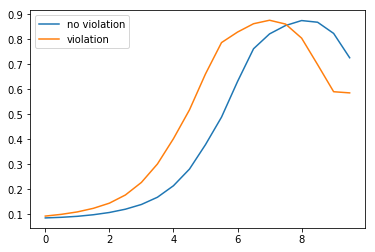

In [15]:
# an example of CCPs
# region 2, lag investment = 0, regular violator

plt.plot(np.arange(0., 10., 0.5), CCP_inv_no_euler[1, 0, 1, :, 0], label="no violation")
plt.plot(np.arange(0., 10., 0.5), CCP_inv_no_euler[1, 0, 1, :, 1], label="violation")

plt.legend()

# 2) Nested fixed point quasi-maximum likelihood estimation.

## a. Report the quasi-likelihood for the parameter vector $\widehat{\theta}$.

In [16]:
quasilikelihood(CCP_inv_no_euler, data)

-6675.635586959141

## b. Maxmize the likelihood for BGL parameters.

$\theta = \left(-2.948, -0.018, -0.303, -0.114, -0.049 \right)$.

Choosing to use "Nelder-Mead" method for nonlinear search.

In [17]:
# ordered by θ_I, θ_F, θ_V, θ_H, θ_X
θ = (-0.018, -0.114, -0.303, -0.049, -2.948)
res = minimize(quasilikelihood_wrapped, θ, args=(data,), method='nelder-mead', options={'xtol': 1e-7, 'disp': True})

Optimization terminated successfully.
         Current function value: 6204.851629
         Iterations: 461
         Function evaluations: 759


In [18]:
θ = res.x
print('θ_I = {:1.3f}, θ_F = {:1.3f}, θ_V = {:1.3f}, θ_H = {:1.3f}, θ_X = {:1.3f}'.format(*θ))

θ_I = -1.299, θ_F = -0.102, θ_V = -2.152, θ_H = 0.452, θ_X = -3.024


The biggest difference bwteen my estimates and the ones in BGL is that $\theta_H$ becomes postive.

# c. Calculate the standard errors

Using the standard outer product approximation method,

$$
\widehat{Var}(\theta^{ML}) = \left[ \sum_{j} \frac{d \log L_j \left( \theta^{ML} \right)}{\theta} \frac{d \log L_j \left( \theta^{ML} \right) ^ \prime}{\theta}\right].
$$

We approximate $\frac{d \log L_j \left( \theta^{ML} \right)}{\theta}$ by

$$
\frac {\log L_j \left( \theta^{ML} + h \right) - \log L_j \left( \theta^{ML} - h \right)} {2h},
$$

where $h$ is a sufficiently small perturbation chosen following https://en.wikipedia.org/wiki/Numerical_differentiation.

In [19]:
# set the difference
h = θ * np.sqrt(np.finfo(float).eps)

In [20]:
# matrices for storing the loglikelihood for perturbed θ
L_right = np.empty((len(θ), data.shape[0]))
L_left = np.empty((len(θ), data.shape[0]))
L_gradient = np.empty((len(θ), data.shape[0]))

# array for stroing the perturbed θ
θ_right = np.empty(len(θ))
θ_left = np.empty(len(θ))

In [21]:
# DAV array for interpolation
DAV_range = np.arange(0., 10.0, 0.5)

# for 1sr to 5th parameter respectively
for i in range(len(θ)):
    θ_right[:] = θ[:]
    θ_left[:] = θ[:]
    
    # calculate CCP for right perturbed θ
    θ_right[i] = θ[i] + h[i]
    VΩ_prime_right, VΩ_right = solve_bellman_jitted(θ_right)
    CCP_inv_right = comute_CCP_inv(VΩ_prime_right, VΩ_right, θ_right)
    
    # calculate CCP for left perturbed θ
    θ_left[i] = θ[i] - h[i]
    VΩ_prime_left, VΩ_left = solve_bellman_jitted(θ_left)
    CCP_inv_left = comute_CCP_inv(VΩ_prime_left, VΩ_left, θ_left)
    
    # for each observation
    for j in range(len(data)):
        region, Linv, ordered_violator, DAV, vio, inv = data[j]
        # interpolate CCP for this observation
        CCP_obs_right = interp(DAV_range, CCP_inv_right[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
        CCP_obs_left = interp(DAV_range, CCP_inv_left[int(region), int(Linv), int(ordered_violator), :, int(vio)], DAV)
        # calculate loglikeligood of this observation
        if inv == 1.:
            L_right[i, j] = np.log(CCP_obs_right)
            L_left[i, j] = np.log(CCP_obs_left)
        else:
            L_right[i, j] = np.log(1 - CCP_obs_right)
            L_left[i, j] = np.log(1 - CCP_obs_left)            
    
    # calculate the approximated gradient
    L_gradient[i] = (L_right[i] - L_left[i]) / (2 * h[i])

    print(f"{i+1}th derivative calculated.")

1th derivative calculated.
2th derivative calculated.
3th derivative calculated.
4th derivative calculated.
5th derivative calculated.


In [22]:
# the variance covariance matrix
varcov = np.linalg.inv(np.dot(L_gradient, L_gradient.T))

print(varcov)

[[ 1.646e-02 -6.685e-04  2.030e-03 -3.907e-03  4.518e-03]
 [-6.685e-04  3.539e-04 -2.392e-03  1.606e-05 -3.352e-04]
 [ 2.030e-03 -2.392e-03  7.330e-02 -3.773e-03  7.262e-03]
 [-3.907e-03  1.606e-05 -3.773e-03  1.375e-03 -1.396e-03]
 [ 4.518e-03 -3.352e-04  7.262e-03 -1.396e-03  3.600e-03]]


In [23]:
# the standard error of each estimated parameter
std = np.sqrt(np.diag(varcov))
print('σ_I = {:1.3f}, σ_F = {:1.3f}, σ_V = {:1.3f}, σ_H = {:1.3f}, σ_X = {:1.3f}'.format(*std))

σ_I = 0.128, σ_F = 0.019, σ_V = 0.271, σ_H = 0.037, σ_X = 0.060


Recall the estimated values were:

In [24]:
print('θ_I = {:1.3f}, θ_F = {:1.3f}, θ_V = {:1.3f}, θ_H = {:1.3f}, θ_X = {:1.3f}'.format(*θ))

θ_I = -1.299, θ_F = -0.102, θ_V = -2.152, θ_H = 0.452, θ_X = -3.024


Which gives us the 95% confidence interval as:

In [25]:
for i, para in enumerate('θ_I,θ_F,θ_V,θ_H,θ_X'.split(',')):
    print(f"95% CI of {para} = [{θ[i]-1.96*std[i]:1.3f}, {θ[i]+1.96*std[i]:1.3f}]")

95% CI of θ_I = [-1.550, -1.047]
95% CI of θ_F = [-0.139, -0.065]
95% CI of θ_V = [-2.683, -1.622]
95% CI of θ_H = [0.380, 0.525]
95% CI of θ_X = [-3.142, -2.907]


Therefore, all the 5 estimates are significant.

# 3) Interpretation of results

## a. What is the implicit cost of investment to a plant in dollars? What about the implicit cost of HPV status, inspections, and violations? Explain.

By evaluating the relative size of the paramter to the one of fines, we can interpret the parameter in terms of dollar measures.

In [26]:
# investment
print(θ[4] / θ[1])

29.744452374952008

The implicit cost of investment to a plant is approximately 29.7 million dollars.

In [27]:
# inspections and violations
print(θ[0] / θ[1], θ[2] / θ[1])

12.773227352630371 21.171355515818377


The implicit cost of inspections and violations are 12.7 and 21.2 million dollars respectively.

In [28]:
# HPV status
print(θ[3] / θ[1])

-4.449774561914695


The weird part of our estimation is that, being HPV status actually gives plant positive earnings which are equivalent to 4.4 million dollars.

## b. What if fines carried a stigma, so that 1 dollar of fines was actually equivalent to $\alpha$ dollar of real cost to the plant? How would this change your implicit costs above? Explain.

The implicit cost is always measured by the real cost. If \$1 of fines is actually equivalent to \$$\alpha$ of real cost, then all the other implicit cost in 3.a will be multiplied by $\alpha$, too.